## Lesson2. The Relationship Between Precipitation and Stream Discharge

In [62]:
import os
import urllib
import math
import matplotlib.pyplot as plt
import pandas as pd
import earthpy as et
import hydrofunctions as hf
import seaborn as sns
%matplotlib inline

In [41]:
# Handle datetime conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [42]:
sns.set(font_scale=1.5, style='whitegrid')

In [43]:
data_path = et.data.get_data('colorado-flood')

Download discharge data

In [44]:
site = '06730500'
start = '1946-05-10'
end = '2018-08-29'

longmost_resp = hf.get_nwis(site, 'dv', start, end)

In [45]:
# Convert to json in order to use extract_nwis_df
longmost_resp = longmost_resp.json()

In [46]:
hf.get_nwis(site, 'dv').json()

{'name': 'ns1:timeSeriesResponseType',
 'declaredType': 'org.cuahsi.waterml.TimeSeriesResponseType',
 'scope': 'javax.xml.bind.JAXBElement$GlobalScope',
 'value': {'queryInfo': {'queryURL': 'http://waterservices.usgs.gov/nwis/dv/format=json%2C1.1&sites=06730500&parameterCd=00060',
   'criteria': {'locationParam': '[ALL:06730500]',
    'variableParam': '[00060]',
    'parameter': []},
   'note': [{'value': '[ALL:06730500]', 'title': 'filter:sites'},
    {'value': '[mode=LATEST, modifiedSince=null]',
     'title': 'filter:timeRange'},
    {'value': 'methodIds=[ALL]', 'title': 'filter:methodId'},
    {'value': '2021-02-06T03:08:59.155Z', 'title': 'requestDT'},
    {'value': 'a800d720-6828-11eb-8624-005056beda50', 'title': 'requestId'},
    {'value': 'Provisional data are subject to revision. Go to http://waterdata.usgs.gov/nwis/help/?provisional for more information.',
     'title': 'disclaimer'},
    {'value': 'caas01', 'title': 'server'}]},
  'timeSeries': [{'sourceInfo': {'siteName': '

Convert to DataFrame

In [47]:
longmont_discharge = hf.extract_nwis_df(longmost_resp)

In [48]:
longmont_discharge.columns = ['discharge', 'flag']
longmont_discharge

,discharge,flag
datetime,,
1946-05-10,16.00,A
1946-05-11,19.00,A
1946-05-12,9.00,A
1946-05-13,3.00,A
1946-05-14,7.80,A
...,...,...
2018-08-25,9.86,A
2018-08-26,7.02,A
2018-08-27,4.05,A


Add a year column

In [49]:
longmont_discharge['year'] = longmont_discharge.index.year

In [50]:
dir(longmont_discharge.index)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__inv__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_accessors',
 '_arith_method',
 '_assert_can_do_setop',

In [51]:
longmont_discharge.index.weekofyear[10]

<ipython-input-51-77dbcb2c6534>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  longmont_discharge.index.weekofyear[10]


21

In [52]:
longmont_discharge.iloc[10]

discharge     3.8
flag            A
year         1946
Name: 1946-05-20 00:00:00, dtype: object

Calculate annual max by resampling

In [53]:
longmont_discharge_annual_max = longmont_discharge.resample('AS').max()
longmont_discharge_annual_max.head()

,discharge,flag,year
datetime,,,
1946-01-01,99.0,A,1946.0
1947-01-01,1930.0,A,1947.0
1948-01-01,339.0,A,1948.0
1949-01-01,2010.0,A,1949.0
1950-01-01,NaN,NaN,NaN


Download annual peak flow data from USGS

In [54]:
url = 'https://nwis.waterdata.usgs.gov/nwis/peak?site_no=06730500&agency_cd=USGS&format=rdb'

download_path = os.path.join(os.path.expanduser('~'), 'earth-analytics', 'data',
                             'colorado-flood', 'downloads', 'annual-peak-flow.txt')

request_return = urllib.request.urlretrieve(url, download_path)

In [55]:
request_return

('C:\\Users\\Glen Shennan\\earth-analytics\\data\\colorado-flood\\downloads\\annual-peak-flow.txt',
 <http.client.HTTPMessage at 0x2b06f281580>)

In [56]:
usgs_annual_max = pd.read_csv(download_path,
                              comment='#',
                              sep='\t',
                              parse_dates=['peak_dt'],
                              skiprows=[73],
                              usecols=['peak_dt', 'peak_va'],
                              index_col='peak_dt')

usgs_annual_max.head()

,peak_va
peak_dt,
1927-07-29,407.0
1928-06-04,694.0
1929-07-23,530.0
1930-08-18,353.0
1931-05-29,369.0


In [57]:
usgs_annual_max['year'] = usgs_annual_max.index.year

Remove duplicate years - keep the max discharge value

In [58]:
usgs_annual_max = usgs_annual_max.sort_values('peak_va', ascending=False).drop_duplicates('year').sort_index()

usgs_annual_max.head()

,peak_va,year
peak_dt,,
1927-07-29,407.0,1927
1928-06-04,694.0,1928
1929-07-23,530.0,1929
1930-08-18,353.0,1930
1931-05-29,369.0,1931


Plot calculated vs USGS annual max flow values

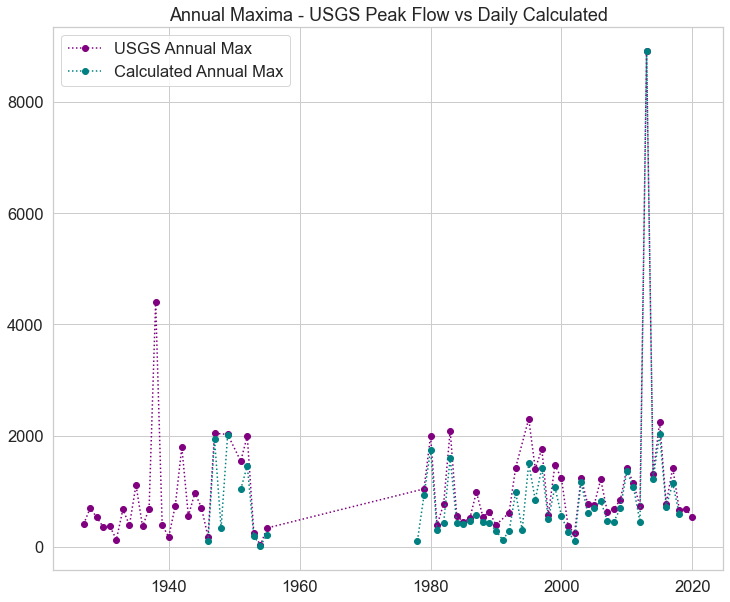

In [65]:
f, ax = plt.subplots(figsize=(12,10))

ax.plot(usgs_annual_max['year'],
        usgs_annual_max['peak_va'],
        color='purple',
        linestyle=':',
        marker='o',
        label='USGS Annual Max')

ax.plot(longmont_discharge_annual_max['year'],
        longmont_discharge_annual_max['discharge'],
        color='teal',
        linestyle=':',
        marker='o',
        label='Calculated Annual Max')

ax.legend()
ax.set_title('Annual Maxima - USGS Peak Flow vs Daily Calculated')

plt.show()

#### Calculate Cumulative Sum

Next create a plot that shows both stream discharge and the total cumulative runnof over the period of interest

1. Calculate the cumulative sum using the .cumsum() pandas method

The USGS site page gives the drainage area: 447 square miles

Convert drainage area to $\text{km}^{2}$

In [76]:
miles2_km2 = 2.58999
site_drainage = 447
longmont_area = site_drainage * miles2_km2

print('The site drainage area in square km is {0}'.format(longmont_area))

The site drainage area in square km is 1157.72553


Next calculate the cumulative sum, convert that to cuf/day then divide by the drainage area

In [79]:
convert_to_cub_f_day = 60*60*24

In [80]:
convert_to_runoff = convert_to_cub_f_day * longmont_area
convert_to_runoff

100027485.792

In [81]:
# MAR - Mean Annual Runoff

In [82]:
longmont_discharge['cum-sum-vol'] = longmont_discharge['discharge'].cumsum() * convert_to_runoff
longmont_discharge.head()

,discharge,flag,year,cum-sum-vol
datetime,,,,
1946-05-10,16.0,A,1946,1.600440e+09
1946-05-11,19.0,A,1946,3.500962e+09
1946-05-12,9.0,A,1946,4.401209e+09
1946-05-13,3.0,A,1946,4.701292e+09
1946-05-14,7.8,A,1946,5.481506e+09


#### Plot Cumulative Sum of Runnoff and Daily Mean Discharge Together

The plot has two series with different Y axes. The line that makes this work is <code>ax2 = ax.twinx()</code>

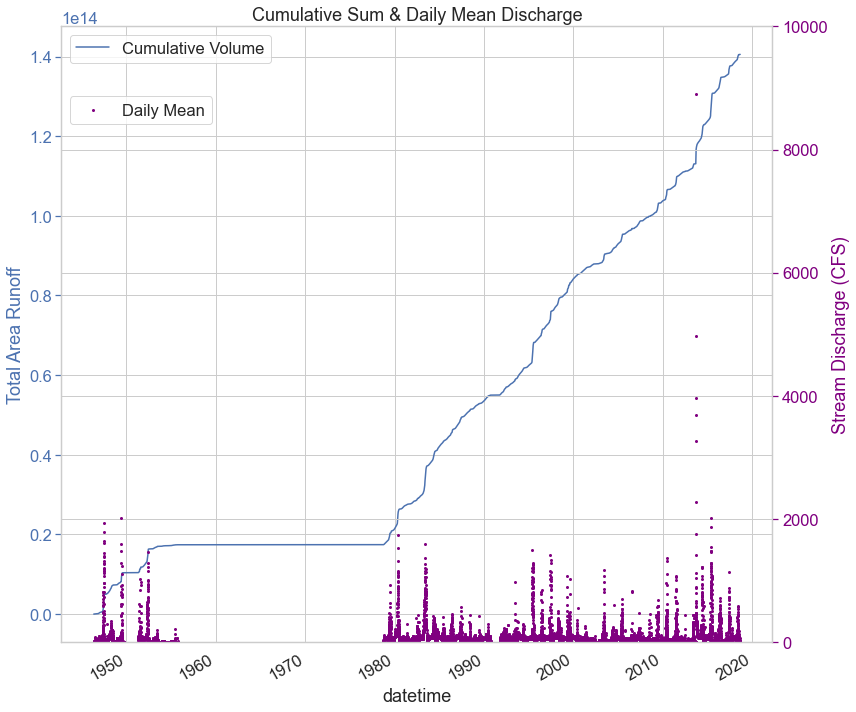

In [84]:
f, ax = plt.subplots(figsize=(12,10))

longmont_discharge['cum-sum-vol'].plot(ax=ax, label='Cumulative Volume')

ax.set_ylabel('Total Area Runoff', color='b')
ax.tick_params('y', colors='b')

ax2 = ax.twinx()

ax2.scatter(x=longmont_discharge.index,
            y=longmont_discharge['discharge'],
            marker='o',
            s=4,
            color='purple',
            label='Daily Mean')
ax2.set_ylabel('Stream Discharge (CFS)', color='purple')
ax2.tick_params('y', colors='purple')
ax2.set_ylim(0,10000)

ax.set_title('Cumulative Sum & Daily Mean Discharge')
ax.legend()

# Reposition second legend so it renders under the first legend item
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9))

f.tight_layout()

plt.show()